In [1]:
# Import Dependencies

import csv
import json
import random
import sys
import time
import uuid
from collections import defaultdict
from pathlib import Path
from datetime import datetime, timedelta
import boto3
import botocore
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from botocore.exceptions import ClientError
from packaging import version

In [9]:
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

In [2]:
# Keep things deterministic
RANDOM_SEED = 0

# Where to put the generated data so that it is picked up by stage.sh
GENERATED_DATA_ROOT = "data"

# Interactions will be generated between these dates
FIRST_TIMESTAMP = int((datetime.now() - timedelta(days=7)).timestamp())
LAST_TIMESTAMP = int(datetime.now().timestamp())

# Users are set up with 3 news categories on their personas. If [0.6, 0.25, 0.15] it means
# 60% of the time they'll choose a news from the first category, etc.
CATEGORY_AFFINITY_PROBS = [0.5, 0.25, 0.15, 0.10]

# After a news, there are this many news within the category that a user is likely to jump on next.
# The purpose of this is to keep recommendations focused within the category if there are too many news
# in a category, because at present the user profiles approach samples news from a category.
NEWS_AFFINITY_N = 4

# from 0 to 1. If 0 then news in busy categories get represented less. If 1 then all news same amount.
NORMALISE_PER_PRODUCT_WEIGHT = 1.0

# With this probability a news interaction will be with the news discounted
# Here we go the other way - what is the probability that a news that a user is already interacting
# with is discounted - depending on whether user likes discounts or not
# DISCOUNT_PROBABILITY = 0.2
# DISCOUNT_PROBABILITY_WITH_PREFERENCE = 0.5

IN_PRODUCTS_FILENAME = "rss-feed-3"
IN_USERS_FILENAME = "users.json.gz"

PROGRESS_MONITOR_SECONDS_UPDATE = 30

# This is where stage.sh will pick them up from
out_items_filename = f"{GENERATED_DATA_ROOT}/items.csv"
out_items_raw_filename = f"{GENERATED_DATA_ROOT}/items_raw.csv"
out_users_filename = f"{GENERATED_DATA_ROOT}/users.csv"
out_interactions_filename = f"{GENERATED_DATA_ROOT}/interactions.csv"

# The meaning of the below constants is described in the relevant notebook.

# Minimum number of interactions to generate
min_interactions = 50000
# min_interactions = 50000

# Percentages of each event type to generate
# view_news_percent = .07
news_liked_percent = .1
news_bookmarked_percent = .05
news_shared_percent = .02

In [3]:
mpl.font_manager.fontManager.addfont("thsarabunnew-webfont.ttf")
mpl.rc("font", family="TH Sarabun New")

In [4]:
news = []
for line in open(IN_PRODUCTS_FILENAME, 'r').readlines():
    parsed_line = json.loads(line)
    news.append(parsed_line['_source'])

news_df = pd.DataFrame(news)

In [5]:
# news_df = pd.read_csv("data/items_raw.csv")
# news_df = news_df.rename({'CATEGORY': 'category'})

In [6]:
news_df.head()

,id,source,pubDate,url,image,title,summary,category,tags,raw_html_content
0,611c0d00-47c3-4234-8916-b5e0b958fb00,hackernoon,2019-07-11T12:03:29+00:00,https://hackernoon.com/deep-aging-scientists-s...,https://hackernoon.com/images/gaZTNviyRwbJIkQm...,Deep Aging: Scientists Say AI Is Getting Bette...,Read the full story,ai,"[artificial-intelligence, ai, aging, aging-wel...","<div class=""Container-sc-11afu3a-0 Story__Layo..."
1,5254a101-cd9d-4552-9608-542ea3875800,hackernoon,2019-07-07T17:16:43+00:00,https://hackernoon.com/probability-for-machine...,https://hackernoon.com/images/gaZTNviyRwbJIkQm...,Probability for Machine Learning,Read the full story,data-science,"[machine-learning, probability, data-science, ...","<div class=""Container-sc-11afu3a-0 Story__Layo..."
2,c66bc572-392e-46f2-840e-e67615bdfad7,hackernoon,2019-06-25T20:13:00+00:00,https://hackernoon.com/serp-analysis-with-goog...,https://hackernoon.com/images/gaZTNviyRwbJIkQm...,SERP Analysis with Google Search Console+Python,Read the full story,data-science,"[seo, data-science]","<div class=""Container-sc-11afu3a-0 Story__Layo..."
3,d6b7da9c-cc6f-4e5d-be39-365e019f8dd7,hackernoon,2019-05-09T13:36:50+00:00,https://hackernoon.com/how-to-run-tensorboard-...,https://hackernoon.com/images/gaZTNviyRwbJIkQm...,How to run Tensorboard for PyTorch 1.1.0 insid...,Read the full story,deep-learning,"[pytorch, deep-learning, tensorboard, jupyter-...","<div class=""Container-sc-11afu3a-0 Story__Layo..."
4,6cbb8c75-1323-4a99-98fa-347125edfa4f,hackernoon,2019-06-17T20:02:33+00:00,https://hackernoon.com/future-of-capitalism-in...,https://hackernoon.com/images/gaZTNviyRwbJIkQm...,Future of capitalism in the age of AI,Read the full story,data-science,"[politics, artificial-intelligence, data-scien...","<div class=""Container-sc-11afu3a-0 Story__Layo..."


In [7]:
news_df = news_df[news_df['pubDate'] > (datetime.now() - timedelta(days=12)).isoformat()]

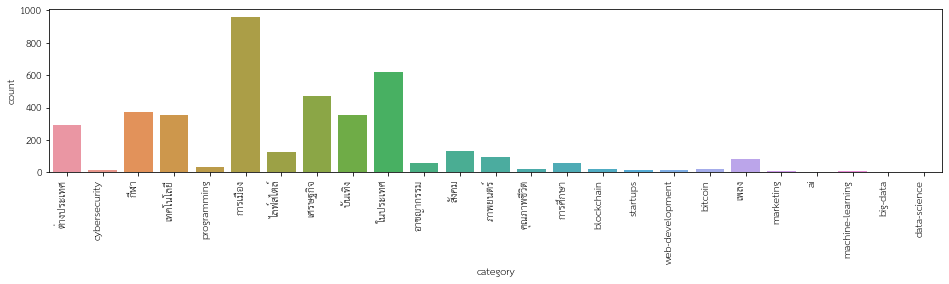

In [8]:
plt.figure(figsize=(16, 3))
chart = sns.countplot(data=news_df, x="category")
plt.xticks(rotation=90, horizontalalignment="right")
plt.show()

In [12]:
allowed_category = [
    "การเมือง",
    "เศรษฐกิจ",
    "ต่างประเทศ",
    "บันเทิง",
    "ในประเทศ",
    "กีฬา",
    "ไลฟ์สไตล์",
    "เทคโนโลยี",
    "สังคม",
    # "คุณภาพชีวิต",
    "การศึกษา",
    "อาชญากรรม",
    "ภาพยนตร์",
]

df = news_df[news_df['category'].isin(allowed_category)]
df.groupby('category').count()

,id,source,pubDate,url,image,title,summary,tags,raw_html_content
category,,,,,,,,,
การศึกษา,59,59,59,59,59,59,59,59,59
การเมือง,958,958,958,958,958,958,958,958,958
กีฬา,373,373,373,373,373,373,373,373,373
ต่างประเทศ,291,291,291,291,291,291,291,291,291
บันเทิง,352,352,352,352,352,352,352,352,352
ภาพยนตร์,98,98,98,98,98,98,98,98,98
สังคม,131,131,131,131,131,131,131,131,131
อาชญากรรม,60,60,60,60,60,60,60,60,60
เทคโนโลยี,352,352,352,352,352,352,352,352,352


In [10]:
category_frequencies = news_df.category.value_counts()
category_frequencies /= sum(category_frequencies.values)

In [60]:
category_frequencies

การเมือง            0.231698
ในประเทศ            0.150036
เศรษฐกิจ            0.114762
กีฬา                0.090118
เทคโนโลยี           0.085045
บันเทิง             0.085045
ต่างประเทศ          0.070307
สังคม               0.031650
ไลฟ์สไตล์           0.030684
ภาพยนตร์            0.023677
เพลง                0.020053
อาชญากรรม           0.014496
การศึกษา            0.014255
programming         0.008698
คุณภาพชีวิต         0.004832
bitcoin             0.004590
blockchain          0.004590
web-development     0.003141
cybersecurity       0.003141
startups            0.002899
machine-learning    0.002174
marketing           0.001933
ai                  0.001208
data-science        0.000725
big-data            0.000242
Name: category, dtype: float64

In [61]:
category_affinity_probs = np.array(CATEGORY_AFFINITY_PROBS)

In [68]:
preferred_categories = 'การศึกษา_เทคโนโลยี_ต่างประเทศ_การเมือง'.split('_')
p_normalised = (category_affinity_probs * category_frequencies[preferred_categories].values)
p_normalised /= p_normalised.sum()

In [69]:
p_normalised

array([0.11476366, 0.34234585, 0.16981132, 0.37307917])

In [71]:
NORMALISE_PER_PRODUCT_WEIGHT = 0.35
p = NORMALISE_PER_PRODUCT_WEIGHT * p_normalised + (1-NORMALISE_PER_PRODUCT_WEIGHT) * category_affinity_probs
p

array([0.36516728, 0.28232105, 0.15693396, 0.19557771])